# [TUM - miniprojekt] Przebieg procesu uczenia dla sieci przy użyciu różnych algorytmów optymalizacji
## Autorzy: Agnieszka Klimek (145302), Anna Prałat (145395)

In [1]:
# %pip install torch torchvision tqdm pandas matplotlib seaborn

In [2]:
import os
from typing import List, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [3]:
DATASET_PATH: str = "./datasets"
MODEL_PATH: str = "./models"
RESULT_PATH: str = "./results"

BATCH_SIZE: int = 4

In [4]:
def get_dataset(dataset, mono: bool, batch_size: int = BATCH_SIZE) -> Tuple:
    norms = (0.5,) if mono else (0.5, 0.5, 0.5)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(norms, norms)])

    train_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=True)
    valid_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=False)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [5]:
datasets = {
    "CIFAR10": torchvision.datasets.CIFAR10,
    "FashionMNIST": torchvision.datasets.FashionMNIST,
    "MNIST": torchvision.datasets.MNIST,
}

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


class CNNClassifier(nn.Module):
    def __init__(self, mono: bool, number_of_classes: int = 10) -> None:
        super().__init__()
        self.mono = mono
        self.conv1 = nn.Conv2d(1 if self.mono else 3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * ((4 * 4) if self.mono else (5 * 5)), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_of_classes)

    def forward(self, x) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4) if self.mono else torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
optimizers = {
    "SGD": optim.SGD,
    "AdaGrad": optim.Adagrad,
    "Adam": optim.Adam,
    "AdamW": optim.AdamW,
    "RMSprop": optim.RMSprop,
}

In [8]:
loss_fn = nn.CrossEntropyLoss()


def train_epoch(model, train_loader, optimizer) -> float:
    model.train()
    optimizer = optimizer(model.parameters())

    running_loss = 0.0
    avg_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            avg_loss = running_loss / 2000
            print(f"[{i + 1:5d}] loss: {avg_loss:.3f}")
            running_loss = 0.0

    return avg_loss


def valid_epoch(model, valid_loader) -> float:
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(tqdm(valid_loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

    avg_loss = running_loss / (i + 1)
    return avg_loss

In [9]:
NUMBER_OF_EPOCHS: int = 3

In [10]:
for dataset_name, dataset in datasets.items():
    print(f"DATASET: {dataset_name}")
    mono = not dataset_name == "CIFAR10"
    train_loader, valid_loader = get_dataset(dataset, mono)

    for optimizer_name, optimizer in optimizers.items():
        print(f"OPTIMIZER: {optimizer_name}")

        model = CNNClassifier(mono)
        model.to(device)

        best_vloss = np.inf

        results: List = []

        for epoch_number in range(NUMBER_OF_EPOCHS):
            print(f"EPOCH: {epoch_number + 1} / {NUMBER_OF_EPOCHS}")

            model.train()
            avg_loss = train_epoch(model, train_loader, optimizers["SGD"])

            model.eval()
            avg_vloss = valid_epoch(model, valid_loader)

            results.append(
                {
                    "epoch": epoch_number,
                    "train_loss": avg_loss,
                    "valid_loss": avg_vloss,
                }
            )

            print(f"Train Loss: {avg_loss:.3f}, Valid Loss: {avg_vloss:.3f}")

            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                if not os.path.exists(MODEL_PATH):
                    os.makedirs(MODEL_PATH)
                torch.save(
                    model.state_dict(), f"{MODEL_PATH}/{dataset_name}_{optimizer_name}_model.pth"
                )
            else:
                print(
                    f"Early stopping (no improvement in validation loss in epoch {epoch_number + 1})"
                )
                break

        results_df = pd.DataFrame(results)
        if not os.path.exists(RESULT_PATH):
            os.makedirs(RESULT_PATH)
        results_df.to_csv(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv", index=False)

DATASET: CIFAR10
Files already downloaded and verified
Files already downloaded and verified
OPTIMIZER: SGD
EPOCH: 1 / 3


 16%|█▋        | 2053/12500 [00:06<00:27, 375.63it/s]

[ 2000] loss: 2.301


 32%|███▏      | 4054/12500 [00:11<00:23, 366.62it/s]

[ 4000] loss: 2.287


 48%|████▊     | 6044/12500 [00:17<00:17, 375.38it/s]

[ 6000] loss: 2.260


 64%|██████▍   | 8039/12500 [00:22<00:11, 377.05it/s]

[ 8000] loss: 2.213


 81%|████████  | 10063/12500 [00:27<00:06, 382.53it/s]

[10000] loss: 2.162


 96%|█████████▋| 12041/12500 [00:33<00:01, 331.22it/s]

[12000] loss: 2.102


100%|██████████| 2500/2500 [00:03<00:00, 771.46it/s]


Train Loss: 2.102, Valid Loss: 2.047
EPOCH: 2 / 3


 16%|█▋        | 2055/12500 [00:05<00:27, 378.22it/s]

[ 2000] loss: 2.027


 33%|███▎      | 4076/12500 [00:11<00:22, 378.10it/s]

[ 4000] loss: 1.983


 48%|████▊     | 6046/12500 [00:16<00:16, 380.57it/s]

[ 6000] loss: 1.939


 64%|██████▍   | 8054/12500 [00:21<00:12, 362.42it/s]

[ 8000] loss: 1.898


 80%|████████  | 10059/12500 [00:27<00:06, 374.26it/s]

[10000] loss: 1.857


 97%|█████████▋| 12064/12500 [00:33<00:01, 373.68it/s]

[12000] loss: 1.821


100%|██████████| 2500/2500 [00:03<00:00, 732.22it/s]


Train Loss: 1.821, Valid Loss: 1.777
EPOCH: 3 / 3


 16%|█▋        | 2060/12500 [00:07<00:32, 325.63it/s]

[ 2000] loss: 1.734


 32%|███▏      | 4048/12500 [00:13<00:22, 371.75it/s]

[ 4000] loss: 1.707


 48%|████▊     | 6045/12500 [00:19<00:19, 337.37it/s]

[ 6000] loss: 1.693


 64%|██████▍   | 8050/12500 [00:25<00:12, 358.06it/s]

[ 8000] loss: 1.666


 80%|████████  | 10061/12500 [00:31<00:06, 382.78it/s]

[10000] loss: 1.649


 96%|█████████▋| 12044/12500 [00:36<00:01, 379.48it/s]

[12000] loss: 1.633


100%|██████████| 2500/2500 [00:03<00:00, 759.12it/s]


Train Loss: 1.633, Valid Loss: 1.618
OPTIMIZER: AdaGrad
EPOCH: 1 / 3


 17%|█▋        | 2067/12500 [00:05<00:27, 379.69it/s]

[ 2000] loss: 2.303


 33%|███▎      | 4063/12500 [00:11<00:22, 368.32it/s]

[ 4000] loss: 2.302


 49%|████▊     | 6064/12500 [00:16<00:16, 382.32it/s]

[ 6000] loss: 2.301


 65%|██████▍   | 8063/12500 [00:22<00:11, 383.00it/s]

[ 8000] loss: 2.298


 81%|████████  | 10070/12500 [00:27<00:06, 389.19it/s]

[10000] loss: 2.293


 97%|█████████▋| 12072/12500 [00:32<00:01, 381.94it/s]

[12000] loss: 2.269


100%|██████████| 2500/2500 [00:03<00:00, 808.75it/s]


Train Loss: 2.269, Valid Loss: 2.228
EPOCH: 2 / 3


 17%|█▋        | 2063/12500 [00:05<00:27, 379.23it/s]

[ 2000] loss: 2.189


 33%|███▎      | 4075/12500 [00:10<00:22, 380.51it/s]

[ 4000] loss: 2.093


 49%|████▊     | 6070/12500 [00:15<00:16, 379.33it/s]

[ 6000] loss: 2.029


 64%|██████▍   | 8047/12500 [00:21<00:12, 365.44it/s]

[ 8000] loss: 1.987


 80%|████████  | 10054/12500 [00:27<00:07, 328.54it/s]

[10000] loss: 1.965


 97%|█████████▋| 12066/12500 [00:32<00:01, 351.25it/s]

[12000] loss: 1.911


100%|██████████| 2500/2500 [00:03<00:00, 767.90it/s]


Train Loss: 1.911, Valid Loss: 1.881
EPOCH: 3 / 3


 16%|█▋        | 2059/12500 [00:05<00:29, 358.25it/s]

[ 2000] loss: 1.883


 32%|███▏      | 4045/12500 [00:11<00:21, 384.50it/s]

[ 4000] loss: 1.840


 48%|████▊     | 6047/12500 [00:16<00:16, 384.23it/s]

[ 6000] loss: 1.788


 64%|██████▍   | 8049/12500 [00:21<00:11, 381.37it/s]

[ 8000] loss: 1.762


 81%|████████  | 10075/12500 [00:27<00:06, 370.38it/s]

[10000] loss: 1.735


 96%|█████████▋| 12054/12500 [00:32<00:01, 382.71it/s]

[12000] loss: 1.692


100%|██████████| 2500/2500 [00:03<00:00, 752.48it/s]


Train Loss: 1.692, Valid Loss: 1.692
OPTIMIZER: Adam
EPOCH: 1 / 3


 16%|█▋        | 2059/12500 [00:05<00:27, 379.77it/s]

[ 2000] loss: 2.304


 32%|███▏      | 4044/12500 [00:10<00:22, 370.85it/s]

[ 4000] loss: 2.300


 48%|████▊     | 6047/12500 [00:16<00:17, 371.38it/s]

[ 6000] loss: 2.293


 64%|██████▍   | 8062/12500 [00:21<00:12, 367.43it/s]

[ 8000] loss: 2.273


 80%|████████  | 10054/12500 [00:27<00:06, 379.54it/s]

[10000] loss: 2.228


 96%|█████████▋| 12050/12500 [00:32<00:01, 373.63it/s]

[12000] loss: 2.175


100%|██████████| 2500/2500 [00:03<00:00, 769.80it/s]


Train Loss: 2.175, Valid Loss: 2.128
EPOCH: 2 / 3


 16%|█▋        | 2052/12500 [00:05<00:27, 385.96it/s]

[ 2000] loss: 2.101


 33%|███▎      | 4066/12500 [00:10<00:22, 377.09it/s]

[ 4000] loss: 2.049


 48%|████▊     | 6045/12500 [00:15<00:16, 383.40it/s]

[ 6000] loss: 2.007


 64%|██████▍   | 8061/12500 [00:21<00:11, 384.18it/s]

[ 8000] loss: 1.955


 80%|████████  | 10044/12500 [00:26<00:06, 382.75it/s]

[10000] loss: 1.923


 96%|█████████▋| 12060/12500 [00:31<00:01, 379.54it/s]

[12000] loss: 1.904


100%|██████████| 2500/2500 [00:03<00:00, 772.84it/s]


Train Loss: 1.904, Valid Loss: 1.863
EPOCH: 3 / 3


 16%|█▋        | 2057/12500 [00:05<00:27, 375.48it/s]

[ 2000] loss: 1.859


 32%|███▏      | 4039/12500 [00:11<00:23, 355.59it/s]

[ 4000] loss: 1.831


 48%|████▊     | 6060/12500 [00:17<00:17, 377.98it/s]

[ 6000] loss: 1.820


 65%|██████▍   | 8074/12500 [00:23<00:13, 335.48it/s]

[ 8000] loss: 1.759


 80%|████████  | 10042/12500 [00:30<00:08, 285.42it/s]

[10000] loss: 1.766


 97%|█████████▋| 12070/12500 [00:36<00:01, 380.62it/s]

[12000] loss: 1.744


100%|██████████| 2500/2500 [00:03<00:00, 703.20it/s]


Train Loss: 1.744, Valid Loss: 1.699
OPTIMIZER: AdamW
EPOCH: 1 / 3


 16%|█▋        | 2054/12500 [00:05<00:28, 361.80it/s]

[ 2000] loss: 2.302


 33%|███▎      | 4072/12500 [00:10<00:21, 384.95it/s]

[ 4000] loss: 2.300


 49%|████▊     | 6068/12500 [00:15<00:16, 385.38it/s]

[ 6000] loss: 2.297


 64%|██████▍   | 8055/12500 [00:21<00:12, 368.24it/s]

[ 8000] loss: 2.290


 80%|████████  | 10036/12500 [00:30<00:08, 283.78it/s]

[10000] loss: 2.271


 97%|█████████▋| 12077/12500 [00:36<00:01, 385.93it/s]

[12000] loss: 2.210


100%|██████████| 2500/2500 [00:03<00:00, 775.38it/s]


Train Loss: 2.210, Valid Loss: 2.095
EPOCH: 2 / 3


 16%|█▋        | 2052/12500 [00:06<00:34, 303.02it/s]

[ 2000] loss: 2.039


 32%|███▏      | 4038/12500 [00:12<00:22, 373.66it/s]

[ 4000] loss: 1.968


 49%|████▊     | 6067/12500 [00:17<00:17, 364.74it/s]

[ 6000] loss: 1.892


 64%|██████▍   | 8055/12500 [00:23<00:12, 369.80it/s]

[ 8000] loss: 1.836


 80%|████████  | 10050/12500 [00:29<00:07, 349.60it/s]

[10000] loss: 1.780


 97%|█████████▋| 12070/12500 [00:35<00:01, 344.83it/s]

[12000] loss: 1.728


100%|██████████| 2500/2500 [00:03<00:00, 673.01it/s]


Train Loss: 1.728, Valid Loss: 1.702
EPOCH: 3 / 3


 16%|█▋        | 2047/12500 [00:05<00:27, 383.12it/s]

[ 2000] loss: 1.674


 32%|███▏      | 4045/12500 [00:10<00:22, 382.23it/s]

[ 4000] loss: 1.659


 48%|████▊     | 6061/12500 [00:16<00:16, 385.24it/s]

[ 6000] loss: 1.636


 64%|██████▍   | 8038/12500 [00:21<00:12, 358.83it/s]

[ 8000] loss: 1.605


 80%|████████  | 10006/12500 [00:27<00:08, 286.04it/s]

[10000] loss: 1.585


 96%|█████████▋| 12044/12500 [00:33<00:01, 326.57it/s]

[12000] loss: 1.574


100%|██████████| 2500/2500 [00:03<00:00, 723.11it/s]


Train Loss: 1.574, Valid Loss: 1.557
OPTIMIZER: RMSprop
EPOCH: 1 / 3


 17%|█▋        | 2065/12500 [00:05<00:28, 371.81it/s]

[ 2000] loss: 2.305


 32%|███▏      | 4057/12500 [00:11<00:22, 371.59it/s]

[ 4000] loss: 2.301


 48%|████▊     | 6061/12500 [00:16<00:17, 370.94it/s]

[ 6000] loss: 2.296


 64%|██████▍   | 8053/12500 [00:22<00:12, 369.12it/s]

[ 8000] loss: 2.284


 81%|████████  | 10064/12500 [00:28<00:06, 365.60it/s]

[10000] loss: 2.240


 96%|█████████▋| 12060/12500 [00:33<00:01, 378.20it/s]

[12000] loss: 2.142


100%|██████████| 2500/2500 [00:03<00:00, 734.57it/s]


Train Loss: 2.142, Valid Loss: 2.097
EPOCH: 2 / 3


 16%|█▋        | 2055/12500 [00:05<00:28, 360.57it/s]

[ 2000] loss: 2.062


 32%|███▏      | 4036/12500 [00:11<00:25, 336.45it/s]

[ 4000] loss: 1.990


 48%|████▊     | 6042/12500 [00:17<00:17, 372.66it/s]

[ 6000] loss: 1.895


 64%|██████▍   | 8061/12500 [00:23<00:12, 353.85it/s]

[ 8000] loss: 1.826


 80%|████████  | 10057/12500 [00:30<00:07, 312.15it/s]

[10000] loss: 1.766


 96%|█████████▋| 12045/12500 [00:35<00:01, 382.36it/s]

[12000] loss: 1.741


100%|██████████| 2500/2500 [00:03<00:00, 761.95it/s]


Train Loss: 1.741, Valid Loss: 1.689
EPOCH: 3 / 3


 16%|█▋        | 2058/12500 [00:05<00:28, 369.73it/s]

[ 2000] loss: 1.701


 33%|███▎      | 4077/12500 [00:10<00:22, 380.66it/s]

[ 4000] loss: 1.667


 49%|████▊     | 6066/12500 [00:16<00:16, 384.30it/s]

[ 6000] loss: 1.637


 64%|██████▍   | 8055/12500 [00:21<00:11, 377.29it/s]

[ 8000] loss: 1.579


 81%|████████  | 10077/12500 [00:26<00:06, 384.20it/s]

[10000] loss: 1.591


 96%|█████████▋| 12055/12500 [00:31<00:01, 310.58it/s]

[12000] loss: 1.572


100%|██████████| 2500/2500 [00:03<00:00, 661.05it/s]


Train Loss: 1.572, Valid Loss: 1.528
DATASET: FashionMNIST


100%|██████████| 26421880/26421880 [00:01<00:00, 17255771.62it/s]


Extracting ./datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 1180314.09it/s]

Extracting ./datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 11562407.92it/s]


Extracting ./datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6686985.75it/s]

Extracting ./datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



OPTIMIZER: SGD
EPOCH: 1 / 3


 14%|█▎        | 2036/15000 [00:06<00:44, 291.86it/s]

[ 2000] loss: 2.287


 27%|██▋       | 4069/15000 [00:13<00:30, 362.78it/s]

[ 4000] loss: 2.154


 40%|████      | 6041/15000 [00:18<00:24, 370.89it/s]

[ 6000] loss: 1.318


 54%|█████▎    | 8053/15000 [00:23<00:20, 341.07it/s]

[ 8000] loss: 0.835


 67%|██████▋   | 10065/15000 [00:28<00:12, 384.19it/s]

[10000] loss: 0.759


 81%|████████  | 12078/15000 [00:33<00:07, 393.36it/s]

[12000] loss: 0.682


 94%|█████████▎| 14056/15000 [00:38<00:02, 415.50it/s]

[14000] loss: 0.675


100%|██████████| 2500/2500 [00:02<00:00, 842.49it/s]


Train Loss: 0.675, Valid Loss: 0.650
EPOCH: 2 / 3


 14%|█▎        | 2031/15000 [00:06<00:53, 242.71it/s]

[ 2000] loss: 0.611


 27%|██▋       | 4051/15000 [00:12<00:27, 398.57it/s]

[ 4000] loss: 0.603


 40%|████      | 6035/15000 [00:17<00:28, 309.76it/s]

[ 6000] loss: 0.592


 54%|█████▍    | 8082/15000 [00:22<00:16, 411.21it/s]

[ 8000] loss: 0.567


 67%|██████▋   | 10040/15000 [00:28<00:13, 381.34it/s]

[10000] loss: 0.557


 80%|████████  | 12063/15000 [00:34<00:08, 351.19it/s]

[12000] loss: 0.573


 94%|█████████▎| 14056/15000 [00:39<00:02, 392.78it/s]

[14000] loss: 0.523


100%|██████████| 2500/2500 [00:03<00:00, 822.76it/s]


Train Loss: 0.523, Valid Loss: 0.539
EPOCH: 3 / 3


 14%|█▎        | 2057/15000 [00:05<00:32, 403.53it/s]

[ 2000] loss: 0.530


 27%|██▋       | 4079/15000 [00:10<00:27, 403.71it/s]

[ 4000] loss: 0.516


 40%|████      | 6073/15000 [00:15<00:21, 406.83it/s]

[ 6000] loss: 0.493


 54%|█████▎    | 8054/15000 [00:20<00:17, 405.47it/s]

[ 8000] loss: 0.499


 67%|██████▋   | 10072/15000 [00:25<00:12, 398.28it/s]

[10000] loss: 0.485


 80%|████████  | 12057/15000 [00:31<00:07, 404.33it/s]

[12000] loss: 0.494


 94%|█████████▍| 14064/15000 [00:36<00:02, 402.35it/s]

[14000] loss: 0.474


100%|██████████| 2500/2500 [00:03<00:00, 741.53it/s]


Train Loss: 0.474, Valid Loss: 0.477
OPTIMIZER: AdaGrad
EPOCH: 1 / 3


 14%|█▎        | 2062/15000 [00:05<00:33, 389.68it/s]

[ 2000] loss: 2.295


 27%|██▋       | 4074/15000 [00:11<00:29, 366.99it/s]

[ 4000] loss: 2.253


 40%|████      | 6041/15000 [00:17<00:23, 382.21it/s]

[ 6000] loss: 1.678


 54%|█████▍    | 8074/15000 [00:22<00:18, 382.30it/s]

[ 8000] loss: 0.914


 67%|██████▋   | 10075/15000 [00:28<00:12, 407.11it/s]

[10000] loss: 0.813


 80%|████████  | 12046/15000 [00:33<00:07, 410.14it/s]

[12000] loss: 0.748


 94%|█████████▎| 14050/15000 [00:38<00:02, 378.64it/s]

[14000] loss: 0.724


100%|██████████| 2500/2500 [00:03<00:00, 749.67it/s]


Train Loss: 0.724, Valid Loss: 0.731
EPOCH: 2 / 3


 13%|█▎        | 2018/15000 [00:05<00:46, 278.70it/s]

[ 2000] loss: 0.670


 27%|██▋       | 4067/15000 [00:11<00:27, 398.29it/s]

[ 4000] loss: 0.658


 40%|████      | 6062/15000 [00:17<00:32, 273.31it/s]

[ 6000] loss: 0.643


 54%|█████▎    | 8048/15000 [00:22<00:16, 411.16it/s]

[ 8000] loss: 0.620


 67%|██████▋   | 10045/15000 [00:27<00:12, 399.63it/s]

[10000] loss: 0.605


 80%|████████  | 12066/15000 [00:32<00:07, 408.62it/s]

[12000] loss: 0.588


 94%|█████████▍| 14073/15000 [00:37<00:02, 412.26it/s]

[14000] loss: 0.585


100%|██████████| 2500/2500 [00:02<00:00, 836.08it/s]


Train Loss: 0.585, Valid Loss: 0.593
EPOCH: 3 / 3


 14%|█▎        | 2056/15000 [00:05<00:31, 409.29it/s]

[ 2000] loss: 0.561


 27%|██▋       | 4053/15000 [00:10<00:26, 410.45it/s]

[ 4000] loss: 0.561


 40%|████      | 6067/15000 [00:16<00:23, 385.54it/s]

[ 6000] loss: 0.563


 54%|█████▍    | 8064/15000 [00:20<00:16, 412.39it/s]

[ 8000] loss: 0.535


 67%|██████▋   | 10058/15000 [00:25<00:12, 411.48it/s]

[10000] loss: 0.515


 80%|████████  | 12067/15000 [00:30<00:07, 412.97it/s]

[12000] loss: 0.509


 94%|█████████▎| 14047/15000 [00:36<00:02, 374.24it/s]

[14000] loss: 0.512


100%|██████████| 2500/2500 [00:03<00:00, 815.54it/s]


Train Loss: 0.512, Valid Loss: 0.520
OPTIMIZER: Adam
EPOCH: 1 / 3


 14%|█▎        | 2043/15000 [00:05<00:31, 406.70it/s]

[ 2000] loss: 2.294


 27%|██▋       | 4063/15000 [00:10<00:27, 400.63it/s]

[ 4000] loss: 2.246


 40%|████      | 6039/15000 [00:15<00:23, 386.30it/s]

[ 6000] loss: 1.798


 54%|█████▎    | 8045/15000 [00:20<00:18, 381.45it/s]

[ 8000] loss: 1.007


 67%|██████▋   | 10058/15000 [00:26<00:13, 359.38it/s]

[10000] loss: 0.841


 80%|████████  | 12043/15000 [00:31<00:09, 324.28it/s]

[12000] loss: 0.752


 94%|█████████▍| 14068/15000 [00:36<00:02, 375.27it/s]

[14000] loss: 0.748


100%|██████████| 2500/2500 [00:03<00:00, 777.67it/s]


Train Loss: 0.748, Valid Loss: 0.747
EPOCH: 2 / 3


 14%|█▍        | 2070/15000 [00:05<00:31, 406.56it/s]

[ 2000] loss: 0.691


 27%|██▋       | 4039/15000 [00:10<00:36, 303.08it/s]

[ 4000] loss: 0.692


 40%|████      | 6054/15000 [00:16<00:26, 341.99it/s]

[ 6000] loss: 0.660


 54%|█████▍    | 8063/15000 [00:21<00:16, 411.40it/s]

[ 8000] loss: 0.659


 67%|██████▋   | 10050/15000 [00:26<00:12, 402.76it/s]

[10000] loss: 0.633


 80%|████████  | 12048/15000 [00:31<00:07, 404.43it/s]

[12000] loss: 0.606


 94%|█████████▍| 14075/15000 [00:37<00:02, 329.39it/s]

[14000] loss: 0.612


100%|██████████| 2500/2500 [00:02<00:00, 849.73it/s]


Train Loss: 0.612, Valid Loss: 0.606
EPOCH: 3 / 3


 14%|█▍        | 2076/15000 [00:05<00:33, 383.73it/s]

[ 2000] loss: 0.579


 27%|██▋       | 4058/15000 [00:10<00:28, 390.33it/s]

[ 4000] loss: 0.585


 40%|████      | 6059/15000 [00:15<00:21, 412.07it/s]

[ 6000] loss: 0.545


 54%|█████▎    | 8050/15000 [00:20<00:17, 405.26it/s]

[ 8000] loss: 0.542


 67%|██████▋   | 10054/15000 [00:25<00:11, 412.91it/s]

[10000] loss: 0.540


 80%|████████  | 12061/15000 [00:30<00:07, 411.03it/s]

[12000] loss: 0.532


 94%|█████████▍| 14073/15000 [00:35<00:02, 411.72it/s]

[14000] loss: 0.540


100%|██████████| 2500/2500 [00:02<00:00, 858.69it/s]


Train Loss: 0.540, Valid Loss: 0.526
OPTIMIZER: AdamW
EPOCH: 1 / 3


 14%|█▎        | 2053/15000 [00:05<00:31, 411.00it/s]

[ 2000] loss: 2.287


 27%|██▋       | 4042/15000 [00:10<00:27, 400.11it/s]

[ 4000] loss: 2.061


 40%|████      | 6068/15000 [00:15<00:24, 365.39it/s]

[ 6000] loss: 1.151


 54%|█████▍    | 8079/15000 [00:20<00:16, 408.89it/s]

[ 8000] loss: 0.910


 67%|██████▋   | 10075/15000 [00:24<00:12, 408.90it/s]

[10000] loss: 0.832


 80%|████████  | 12071/15000 [00:29<00:07, 412.32it/s]

[12000] loss: 0.760


 94%|█████████▎| 14060/15000 [00:34<00:02, 410.20it/s]

[14000] loss: 0.746


100%|██████████| 2500/2500 [00:02<00:00, 852.61it/s]


Train Loss: 0.746, Valid Loss: 0.784
EPOCH: 2 / 3


 14%|█▎        | 2062/15000 [00:05<00:32, 401.95it/s]

[ 2000] loss: 0.684


 27%|██▋       | 4059/15000 [00:10<00:26, 407.60it/s]

[ 4000] loss: 0.667


 40%|████      | 6043/15000 [00:14<00:21, 407.75it/s]

[ 6000] loss: 0.667


 54%|█████▍    | 8065/15000 [00:19<00:17, 403.60it/s]

[ 8000] loss: 0.647


 67%|██████▋   | 10050/15000 [00:24<00:12, 409.68it/s]

[10000] loss: 0.612


 81%|████████  | 12079/15000 [00:29<00:07, 404.46it/s]

[12000] loss: 0.596


 94%|█████████▍| 14070/15000 [00:34<00:02, 408.99it/s]

[14000] loss: 0.569


100%|██████████| 2500/2500 [00:02<00:00, 857.65it/s]


Train Loss: 0.569, Valid Loss: 0.604
EPOCH: 3 / 3


 14%|█▍        | 2077/15000 [00:05<00:31, 411.22it/s]

[ 2000] loss: 0.558


 27%|██▋       | 4073/15000 [00:10<00:26, 410.71it/s]

[ 4000] loss: 0.576


 40%|████      | 6041/15000 [00:14<00:21, 410.11it/s]

[ 6000] loss: 0.539


 54%|█████▍    | 8080/15000 [00:19<00:16, 410.36it/s]

[ 8000] loss: 0.530


 67%|██████▋   | 10050/15000 [00:24<00:12, 411.29it/s]

[10000] loss: 0.525


 80%|████████  | 12060/15000 [00:29<00:07, 408.01it/s]

[12000] loss: 0.508


 94%|█████████▎| 14054/15000 [00:34<00:02, 408.84it/s]

[14000] loss: 0.513


100%|██████████| 2500/2500 [00:02<00:00, 857.80it/s]


Train Loss: 0.513, Valid Loss: 0.511
OPTIMIZER: RMSprop
EPOCH: 1 / 3


 14%|█▍        | 2070/15000 [00:05<00:31, 413.83it/s]

[ 2000] loss: 2.296


 27%|██▋       | 4067/15000 [00:10<00:26, 407.74it/s]

[ 4000] loss: 2.230


 40%|████      | 6065/15000 [00:14<00:21, 408.99it/s]

[ 6000] loss: 1.513


 54%|█████▍    | 8068/15000 [00:19<00:16, 410.07it/s]

[ 8000] loss: 0.901


 67%|██████▋   | 10070/15000 [00:24<00:11, 411.00it/s]

[10000] loss: 0.806


 80%|████████  | 12062/15000 [00:29<00:07, 409.64it/s]

[12000] loss: 0.734


 94%|█████████▎| 14043/15000 [00:34<00:02, 406.87it/s]

[14000] loss: 0.709


100%|██████████| 2500/2500 [00:02<00:00, 843.97it/s]


Train Loss: 0.709, Valid Loss: 0.704
EPOCH: 2 / 3


 14%|█▍        | 2072/15000 [00:05<00:31, 409.23it/s]

[ 2000] loss: 0.678


 27%|██▋       | 4075/15000 [00:10<00:28, 378.57it/s]

[ 4000] loss: 0.652


 40%|████      | 6061/15000 [00:14<00:21, 407.69it/s]

[ 6000] loss: 0.642


 54%|█████▎    | 8057/15000 [00:19<00:16, 408.97it/s]

[ 8000] loss: 0.641


 67%|██████▋   | 10075/15000 [00:24<00:12, 408.52it/s]

[10000] loss: 0.623


 80%|████████  | 12061/15000 [00:29<00:07, 388.80it/s]

[12000] loss: 0.608


 94%|█████████▍| 14064/15000 [00:34<00:02, 409.78it/s]

[14000] loss: 0.596


100%|██████████| 2500/2500 [00:02<00:00, 854.02it/s]


Train Loss: 0.596, Valid Loss: 0.601
EPOCH: 3 / 3


 14%|█▍        | 2079/15000 [00:05<00:31, 409.62it/s]

[ 2000] loss: 0.577


 27%|██▋       | 4078/15000 [00:10<00:26, 410.92it/s]

[ 4000] loss: 0.557


 41%|████      | 6077/15000 [00:15<00:21, 409.09it/s]

[ 6000] loss: 0.560


 54%|█████▍    | 8072/15000 [00:19<00:16, 411.08it/s]

[ 8000] loss: 0.524


 67%|██████▋   | 10079/15000 [00:24<00:11, 410.22it/s]

[10000] loss: 0.547


 80%|████████  | 12075/15000 [00:29<00:07, 408.71it/s]

[12000] loss: 0.549


 94%|█████████▍| 14072/15000 [00:34<00:02, 409.45it/s]

[14000] loss: 0.513


100%|██████████| 2500/2500 [00:02<00:00, 851.37it/s]


Train Loss: 0.513, Valid Loss: 0.530
DATASET: MNIST
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6139467.30it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 240276.13it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2448344.95it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1632715.87it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

OPTIMIZER: SGD
EPOCH: 1 / 3


 14%|█▎        | 2062/15000 [00:05<00:31, 409.98it/s]

[ 2000] loss: 2.299


 27%|██▋       | 4066/15000 [00:10<00:26, 410.41it/s]

[ 4000] loss: 2.285


 40%|████      | 6063/15000 [00:14<00:21, 410.71it/s]

[ 6000] loss: 2.250


 54%|█████▎    | 8054/15000 [00:19<00:17, 408.50it/s]

[ 8000] loss: 1.987


 67%|██████▋   | 10045/15000 [00:24<00:12, 409.33it/s]

[10000] loss: 0.879


 80%|████████  | 12071/15000 [00:29<00:07, 408.35it/s]

[12000] loss: 0.451


 94%|█████████▎| 14046/15000 [00:34<00:02, 406.44it/s]

[14000] loss: 0.343


100%|██████████| 2500/2500 [00:02<00:00, 849.35it/s]


Train Loss: 0.343, Valid Loss: 0.241
EPOCH: 2 / 3


 14%|█▍        | 2071/15000 [00:05<00:31, 409.09it/s]

[ 2000] loss: 0.255


 27%|██▋       | 4033/15000 [00:10<00:30, 356.75it/s]

[ 4000] loss: 0.229


 40%|████      | 6026/15000 [00:16<00:26, 342.29it/s]

[ 6000] loss: 0.206


 54%|█████▍    | 8064/15000 [00:21<00:16, 408.24it/s]

[ 8000] loss: 0.194


 67%|██████▋   | 10073/15000 [00:26<00:11, 411.28it/s]

[10000] loss: 0.170


 80%|████████  | 12044/15000 [00:31<00:07, 408.63it/s]

[12000] loss: 0.173


 94%|█████████▎| 14049/15000 [00:36<00:02, 413.95it/s]

[14000] loss: 0.148


100%|██████████| 2500/2500 [00:02<00:00, 857.10it/s]


Train Loss: 0.148, Valid Loss: 0.123
EPOCH: 3 / 3


 14%|█▎        | 2045/15000 [00:05<00:31, 408.41it/s]

[ 2000] loss: 0.150


 27%|██▋       | 4048/15000 [00:10<00:28, 388.97it/s]

[ 4000] loss: 0.124


 40%|████      | 6053/15000 [00:14<00:21, 414.59it/s]

[ 6000] loss: 0.126


 54%|█████▎    | 8049/15000 [00:19<00:19, 349.25it/s]

[ 8000] loss: 0.120


 67%|██████▋   | 10073/15000 [00:24<00:11, 416.28it/s]

[10000] loss: 0.112


 80%|████████  | 12074/15000 [00:29<00:07, 410.13it/s]

[12000] loss: 0.111


 94%|█████████▍| 14069/15000 [00:34<00:02, 396.78it/s]

[14000] loss: 0.108


100%|██████████| 2500/2500 [00:02<00:00, 890.28it/s]


Train Loss: 0.108, Valid Loss: 0.092
OPTIMIZER: AdaGrad
EPOCH: 1 / 3


 14%|█▍        | 2071/15000 [00:05<00:31, 414.80it/s]

[ 2000] loss: 2.300


 27%|██▋       | 4045/15000 [00:09<00:26, 416.58it/s]

[ 4000] loss: 2.290


 40%|████      | 6061/15000 [00:14<00:21, 416.73it/s]

[ 6000] loss: 2.271


 54%|█████▎    | 8053/15000 [00:19<00:16, 411.81it/s]

[ 8000] loss: 2.184


 67%|██████▋   | 10072/15000 [00:24<00:11, 415.09it/s]

[10000] loss: 1.453


 80%|████████  | 12046/15000 [00:29<00:07, 415.87it/s]

[12000] loss: 0.560


 94%|█████████▍| 14063/15000 [00:34<00:02, 417.44it/s]

[14000] loss: 0.361


100%|██████████| 2500/2500 [00:02<00:00, 889.55it/s]


Train Loss: 0.361, Valid Loss: 0.269
EPOCH: 2 / 3


 14%|█▎        | 2048/15000 [00:05<00:33, 383.13it/s]

[ 2000] loss: 0.247


 27%|██▋       | 4044/15000 [00:10<00:26, 412.84it/s]

[ 4000] loss: 0.222


 40%|████      | 6046/15000 [00:15<00:23, 388.24it/s]

[ 6000] loss: 0.184


 54%|█████▎    | 8057/15000 [00:20<00:16, 415.08it/s]

[ 8000] loss: 0.172


 67%|██████▋   | 10070/15000 [00:25<00:11, 418.09it/s]

[10000] loss: 0.174


 80%|████████  | 12062/15000 [00:30<00:07, 417.79it/s]

[12000] loss: 0.155


 94%|█████████▎| 14045/15000 [00:35<00:02, 420.13it/s]

[14000] loss: 0.148


100%|██████████| 2500/2500 [00:02<00:00, 870.22it/s]


Train Loss: 0.148, Valid Loss: 0.120
EPOCH: 3 / 3


 14%|█▎        | 2059/15000 [00:04<00:31, 415.19it/s]

[ 2000] loss: 0.132


 27%|██▋       | 4081/15000 [00:09<00:26, 415.12it/s]

[ 4000] loss: 0.116


 40%|████      | 6052/15000 [00:15<00:28, 315.04it/s]

[ 6000] loss: 0.121


 54%|█████▎    | 8060/15000 [00:20<00:20, 345.68it/s]

[ 8000] loss: 0.121


 67%|██████▋   | 10039/15000 [00:26<00:12, 400.45it/s]

[10000] loss: 0.116


 80%|████████  | 12075/15000 [00:31<00:07, 388.50it/s]

[12000] loss: 0.107


 94%|█████████▎| 14042/15000 [00:36<00:02, 390.56it/s]

[14000] loss: 0.104


100%|██████████| 2500/2500 [00:03<00:00, 822.43it/s]


Train Loss: 0.104, Valid Loss: 0.083
OPTIMIZER: Adam
EPOCH: 1 / 3


 14%|█▎        | 2056/15000 [00:04<00:31, 413.25it/s]

[ 2000] loss: 2.292


 27%|██▋       | 4054/15000 [00:09<00:26, 418.95it/s]

[ 4000] loss: 2.268


 40%|████      | 6047/15000 [00:14<00:22, 393.48it/s]

[ 6000] loss: 2.148


 54%|█████▎    | 8058/15000 [00:20<00:18, 368.69it/s]

[ 8000] loss: 1.288


 67%|██████▋   | 10057/15000 [00:25<00:11, 414.55it/s]

[10000] loss: 0.549


 80%|████████  | 12075/15000 [00:30<00:07, 414.74it/s]

[12000] loss: 0.395


 94%|█████████▎| 14050/15000 [00:35<00:02, 406.35it/s]

[14000] loss: 0.300


100%|██████████| 2500/2500 [00:02<00:00, 842.71it/s]


Train Loss: 0.300, Valid Loss: 0.225
EPOCH: 2 / 3


 14%|█▍        | 2080/15000 [00:05<00:31, 412.73it/s]

[ 2000] loss: 0.228


 27%|██▋       | 4081/15000 [00:10<00:26, 412.48it/s]

[ 4000] loss: 0.197


 40%|████      | 6049/15000 [00:14<00:21, 408.05it/s]

[ 6000] loss: 0.185


 54%|█████▎    | 8052/15000 [00:20<00:16, 410.84it/s]

[ 8000] loss: 0.170


 67%|██████▋   | 10042/15000 [00:26<00:17, 279.95it/s]

[10000] loss: 0.154


 81%|████████  | 12076/15000 [00:31<00:07, 411.75it/s]

[12000] loss: 0.149


 94%|█████████▎| 14043/15000 [00:36<00:02, 355.56it/s]

[14000] loss: 0.142


100%|██████████| 2500/2500 [00:03<00:00, 713.32it/s]


Train Loss: 0.142, Valid Loss: 0.124
EPOCH: 3 / 3


 14%|█▎        | 2058/15000 [00:05<00:31, 412.55it/s]

[ 2000] loss: 0.126


 27%|██▋       | 4066/15000 [00:10<00:26, 412.23it/s]

[ 4000] loss: 0.112


 40%|████      | 6069/15000 [00:15<00:21, 413.44it/s]

[ 6000] loss: 0.121


 54%|█████▎    | 8045/15000 [00:19<00:16, 412.50it/s]

[ 8000] loss: 0.117


 67%|██████▋   | 10057/15000 [00:24<00:11, 416.90it/s]

[10000] loss: 0.127


 80%|████████  | 12059/15000 [00:29<00:07, 415.98it/s]

[12000] loss: 0.102


 94%|█████████▍| 14075/15000 [00:34<00:02, 414.77it/s]

[14000] loss: 0.103


100%|██████████| 2500/2500 [00:02<00:00, 866.85it/s]


Train Loss: 0.103, Valid Loss: 0.085
OPTIMIZER: AdamW
EPOCH: 1 / 3


 14%|█▎        | 2054/15000 [00:04<00:31, 414.70it/s]

[ 2000] loss: 2.300


 27%|██▋       | 4070/15000 [00:09<00:26, 414.52it/s]

[ 4000] loss: 2.283


 40%|████      | 6044/15000 [00:14<00:21, 415.12it/s]

[ 6000] loss: 2.222


 54%|█████▎    | 8060/15000 [00:19<00:16, 415.26it/s]

[ 8000] loss: 1.648


 67%|██████▋   | 10079/15000 [00:24<00:11, 416.75it/s]

[10000] loss: 0.565


 80%|████████  | 12051/15000 [00:30<00:07, 374.14it/s]

[12000] loss: 0.354


 94%|█████████▍| 14076/15000 [00:35<00:02, 410.13it/s]

[14000] loss: 0.306


100%|██████████| 2500/2500 [00:02<00:00, 879.98it/s]


Train Loss: 0.306, Valid Loss: 0.262
EPOCH: 2 / 3


 14%|█▍        | 2071/15000 [00:05<00:33, 387.54it/s]

[ 2000] loss: 0.255


 27%|██▋       | 4060/15000 [00:11<00:33, 330.21it/s]

[ 4000] loss: 0.216


 40%|████      | 6064/15000 [00:16<00:21, 416.52it/s]

[ 6000] loss: 0.210


 54%|█████▎    | 8059/15000 [00:21<00:16, 413.58it/s]

[ 8000] loss: 0.207


 67%|██████▋   | 10052/15000 [00:26<00:12, 409.95it/s]

[10000] loss: 0.185


 80%|████████  | 12046/15000 [00:31<00:07, 402.82it/s]

[12000] loss: 0.185


 93%|█████████▎| 14018/15000 [00:36<00:02, 349.82it/s]

[14000] loss: 0.169


100%|██████████| 2500/2500 [00:02<00:00, 866.64it/s]


Train Loss: 0.169, Valid Loss: 0.153
EPOCH: 3 / 3


 14%|█▎        | 2041/15000 [00:05<00:33, 382.36it/s]

[ 2000] loss: 0.152


 27%|██▋       | 4068/15000 [00:10<00:26, 413.45it/s]

[ 4000] loss: 0.155


 40%|████      | 6051/15000 [00:15<00:21, 415.29it/s]

[ 6000] loss: 0.141


 54%|█████▍    | 8064/15000 [00:20<00:17, 400.89it/s]

[ 8000] loss: 0.136


 67%|██████▋   | 10073/15000 [00:25<00:11, 414.19it/s]

[10000] loss: 0.135


 80%|████████  | 12064/15000 [00:30<00:07, 407.44it/s]

[12000] loss: 0.125


 94%|█████████▍| 14076/15000 [00:35<00:02, 414.36it/s]

[14000] loss: 0.140


100%|██████████| 2500/2500 [00:02<00:00, 878.47it/s]


Train Loss: 0.140, Valid Loss: 0.112
OPTIMIZER: RMSprop
EPOCH: 1 / 3


 14%|█▎        | 2052/15000 [00:05<00:33, 383.79it/s]

[ 2000] loss: 2.298


 27%|██▋       | 4068/15000 [00:09<00:26, 417.62it/s]

[ 4000] loss: 2.284


 41%|████      | 6076/15000 [00:14<00:22, 398.97it/s]

[ 6000] loss: 2.251


 54%|█████▎    | 8043/15000 [00:19<00:16, 414.15it/s]

[ 8000] loss: 1.997


 67%|██████▋   | 10060/15000 [00:24<00:11, 414.89it/s]

[10000] loss: 0.978


 81%|████████  | 12079/15000 [00:29<00:07, 415.31it/s]

[12000] loss: 0.507


 94%|█████████▎| 14040/15000 [00:34<00:02, 389.92it/s]

[14000] loss: 0.366


100%|██████████| 2500/2500 [00:03<00:00, 675.57it/s]


Train Loss: 0.366, Valid Loss: 0.284
EPOCH: 2 / 3


 14%|█▎        | 2050/15000 [00:04<00:31, 411.92it/s]

[ 2000] loss: 0.278


 27%|██▋       | 4060/15000 [00:09<00:26, 407.20it/s]

[ 4000] loss: 0.254


 40%|████      | 6070/15000 [00:14<00:21, 413.07it/s]

[ 6000] loss: 0.223


 54%|█████▎    | 8058/15000 [00:19<00:17, 408.25it/s]

[ 8000] loss: 0.201


 67%|██████▋   | 10073/15000 [00:24<00:11, 416.19it/s]

[10000] loss: 0.198


 80%|████████  | 12048/15000 [00:29<00:07, 415.25it/s]

[12000] loss: 0.172


 94%|█████████▎| 14042/15000 [00:34<00:02, 414.19it/s]

[14000] loss: 0.173


100%|██████████| 2500/2500 [00:03<00:00, 812.97it/s]


Train Loss: 0.173, Valid Loss: 0.133
EPOCH: 3 / 3


 14%|█▎        | 2061/15000 [00:05<00:32, 400.22it/s]

[ 2000] loss: 0.149


 27%|██▋       | 4077/15000 [00:11<00:26, 411.06it/s]

[ 4000] loss: 0.148


 40%|████      | 6031/15000 [00:16<00:30, 290.99it/s]

[ 6000] loss: 0.137


 54%|█████▎    | 8048/15000 [00:22<00:19, 350.42it/s]

[ 8000] loss: 0.135


 67%|██████▋   | 10068/15000 [00:27<00:12, 407.90it/s]

[10000] loss: 0.121


 80%|████████  | 12059/15000 [00:32<00:07, 413.55it/s]

[12000] loss: 0.111


 94%|█████████▍| 14077/15000 [00:37<00:02, 413.45it/s]

[14000] loss: 0.113


100%|██████████| 2500/2500 [00:02<00:00, 870.91it/s]

Train Loss: 0.113, Valid Loss: 0.108


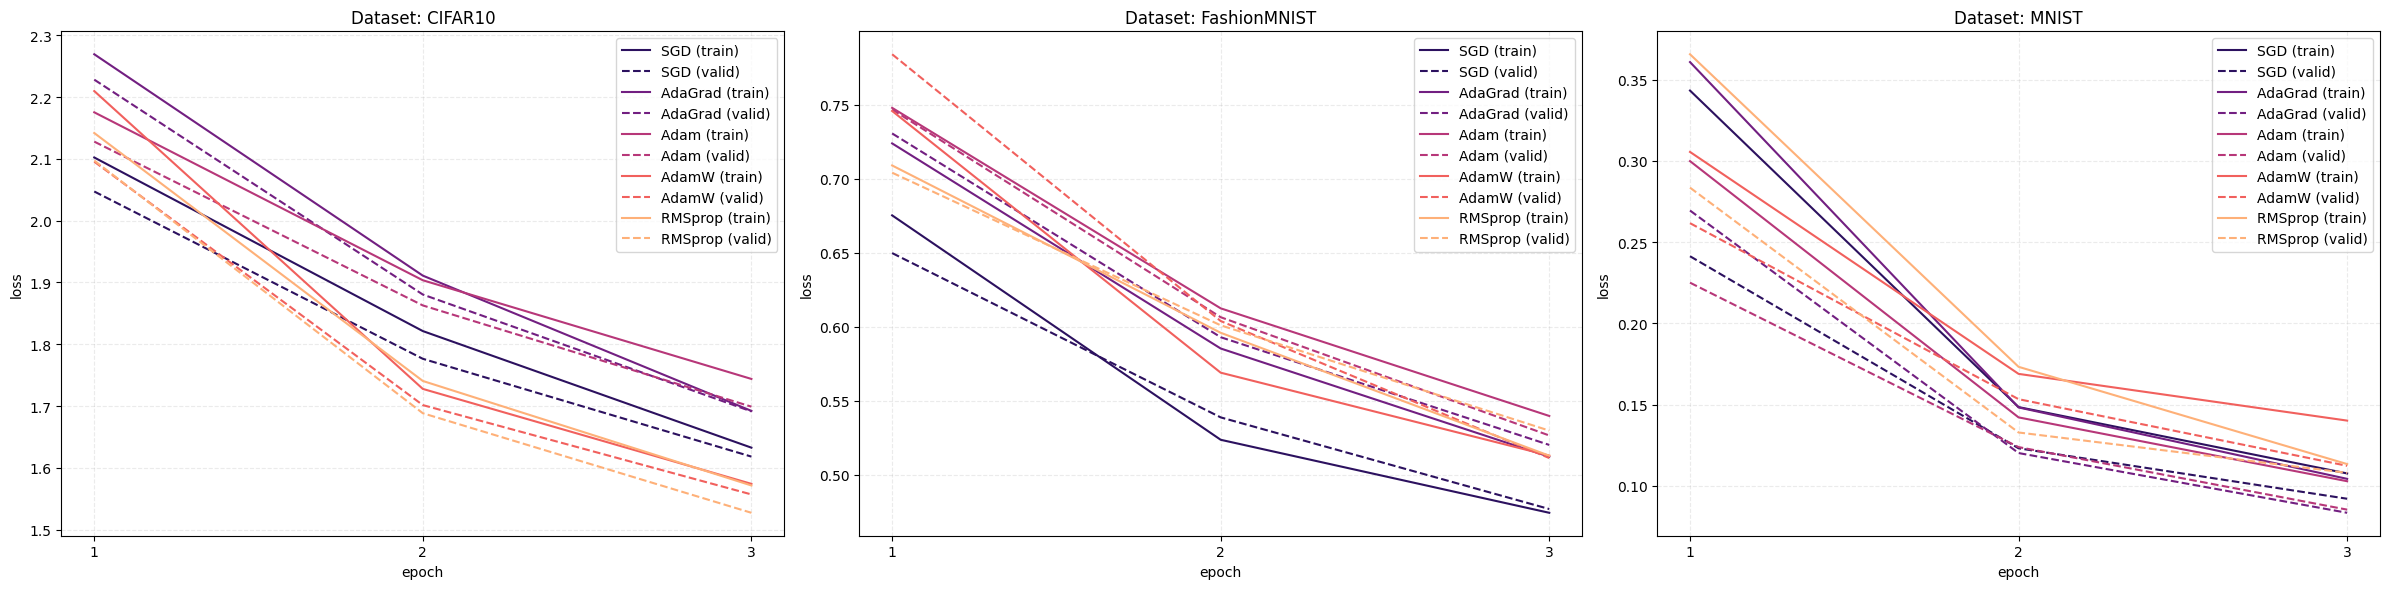

In [18]:
cols = len(datasets)
fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(8 * cols, 6), tight_layout=True)
colors = sns.color_palette("magma", len(optimizers))

for dataset_idx, (dataset_name, dataset) in enumerate(datasets.items()):
    for optimizer_idx, (optimizer_name, optimizer) in enumerate(optimizers.items()):
        results_df = pd.read_csv(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv")
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["train_loss"],
            label=f"{optimizer_name} (train)",
            color=colors[optimizer_idx],
        )
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["valid_loss"],
            label=f"{optimizer_name} (valid)",
            color=colors[optimizer_idx],
            linestyle="--",
        )

    ax[dataset_idx].set_title(f"Dataset: {dataset_name}")
    ax[dataset_idx].set_xticks(np.arange(1, NUMBER_OF_EPOCHS + 1, step=1))
    ax[dataset_idx].set_xlabel("epoch")
    ax[dataset_idx].set_ylabel("loss")
    ax[dataset_idx].grid(linestyle="--", alpha=0.25)
    ax[dataset_idx].legend()

fig.savefig(f"{RESULT_PATH}/plot_loss.png")